In [1]:
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures - run this cell
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import pandas as pd
import sklearn

from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### We will walk through the building of a Regression Neural Network

#### Simple case of a sequential network

In [2]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(11610, 8)
(3870, 8)
(5160, 8)


#### Q - Why was it important to scale the data using standard scalar in this example while in the classification example we just divided by 255? (Stop and ponder!)

In [4]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])


#### Q - What is the shape of this model? What will model.summary() output? Can you predict the number of parameters? (Stop and ponder!)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

#### Q - What do the parameters above in the model.compile() function mean? (Stop and ponder!)

In [7]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 75us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5005 - val_l

#### Q - What does the output from the model training tell you? Specifically the loss and val_loss! (Stop and ponder!)

In [8]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### Q - Is the loss above enough to prove that your model is "good"? What outputs might help us understand underfitting or overfitting? (Stop and ponder!)

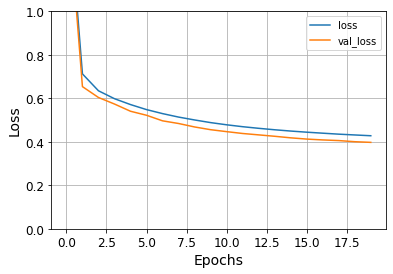

In [9]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(history.history.keys())
plt.show()

#### Q - What does the above graph show you?

### More Complex Models using Functional API

Sometimes we want models that are more complex. "Wide and Deep" models are models that allow some features to run through fewer of the hidden layers than other features, instead of forcing all the data to flow through every layer in the stack.

#### We start by defining the model OUTSIDE of the sequential function.

the layer commands are similar to what we used before, except not we have the concatenate layer

In [10]:
keras.backend.clear_session()

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

#### What do each of these layers do?

- input_ contains the features that you want send into hidden1. Notice we need to specify the shape
- hidden1 is a dense layer with 30 neurons and relu activation that takes input_ as it's input. Notice in Functional API we "send in" the data, input1_, just like we were calling a function
- hidden2 is a dense layer with 30 neurons and relu activation that takes the output from hidden1 as it's input.
- concat allows us to put together the output from hidden2 and a copy of input_. This effectively allows a copy of our features to bypass the hidden layers and go directly into the output.
- output is a dense layer with one neuron and no activation that takes as an input concat.

model builds the keras model specifying the inputs and outputs, the path that the inputs take to get to the outputs is understood from the layers defined above.

#### NOTE: The above network is basically creating a deep neural network combined with a simple linear regression. These two models run side-by-side into the output that uses BOTH to create a prediction.

#### Q - What will model.summary() output? How many parameters do you expect to have? (Stop and ponder!)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [12]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 60us/sample - loss: 1.8716 - val_loss: 2.0992
Epoch 2/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6590 - val_loss: 0.8409
Epoch 3/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5956 - val_loss: 0.6495
Epoch 4/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5629 - val_loss: 0.6644
Epoch 5/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5400 - val_loss: 0.6005
Epoch 6/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5171 - val_loss: 0.8458
Epoch 7/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5058 - val_loss: 0.4805
Epoch 8/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4876 - val_loss: 0.5796
Epoch 9/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4792 - val_l

#### Q - Explain what the outputs above are telling you.

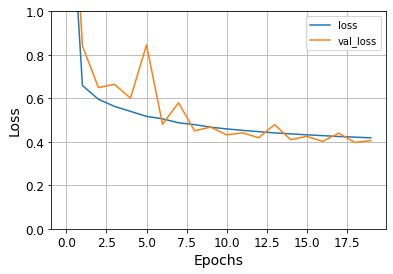

In [13]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(history.history.keys())
plt.show()

### Another example using Functional API

See if you can explain what the following model architecture (topology) will be.

In [14]:
keras.backend.clear_session()

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

#### Seriously STOP AND PONDER! Can you draw or describe what the above code is doing without running model.summary() or looking up the model in the book? Can you figure out the number of parameters?

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [16]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 54us/sample - loss: 2.0042 - val_loss: 0.9797
Epoch 2/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.7905 - val_loss: 0.6946
Epoch 3/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6507 - val_loss: 0.6242
Epoch 4/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5985 - val_loss: 0.5876
Epoch 5/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5668 - val_loss: 0.5435
Epoch 6/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5418 - val_loss: 0.5263
Epoch 7/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5223 - val_loss: 0.4988
Epoch 8/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5064 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4942 - val_l

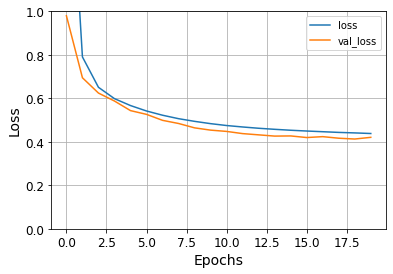

In [17]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(history.history.keys())
plt.show()

#### The above neural network sends some of the data (features) through a deep path and some of the data (features) through a wide path avoiding the neural net. 

When we run model.fit() we send in our data in pieces: 
((X_train_A, X_train_B), y_train, epochs=20,validation_data=((X_valid_A, X_valid_B), y_valid))

X_train_A contains the first six columns or features (cols 0 - 5)
X_train_B contains the last five columns or features (cols 3 - 8)

###### You would have to decide which features should go deep and which go wide!

### Saving and restoring a model

It is often useful to save an already trained model. Sometimes models take a REALLY long time to train and if you don't save all those theta values before you close python, they will be lost, meaning you would have to retrain your model to use it.

Luckily! We can save and restore our models once they are trained!

In [18]:
model.save("Deep_and_Wide_model.h5")

#### The command above saved the Deep and Wide model that was most recently run. Notice the file extension is .h5. 

This command saves everything! The model parameters, the hyperparameters (learning rate etc), the state of the optimizer so if you wanted to keep trining you could.

In [19]:
model_new = keras.models.load_model("Deep_and_Wide_model.h5")

In [20]:
model_new.evaluate((X_test_A, X_test_B), y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.4301532410373983

### Callbacks - You can even save your model within the model.fit() command to save your model during training.

This is really nice when training takes a long time, so you might want to walk away and have a cup of tea, but you want to make sure your model is saved! This also allows you to "rollback" your training if you start to overtrain (remember early stopping?)

In [21]:
# Let's clear the keras session and start fresh.
# clear_session completely clears the model (parameters, structure, etc) that is saved in the current memory
# it will not clear your data

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

#### Q - We are still doing the housing data (regression model), what is the structure defined above?

In [23]:
# Compile the model like normal
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [24]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

#### Here we have defined a Checkpoint that tells the model during training to check during each training epoch and if the model is better than the previous one, save it as "my_keras_model.h5". The model keeps training but only saves data if it got better.

In [25]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 52us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4586 - val_l

#### Can you tell which epoch was the best and this saved by the callback?

In [26]:
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### You should explore the keras documentation. There are lots of other callbacks, for example you can specify "early stopping".

### TensorBoard - allows you to visualize your training process

In [27]:
# Allow Python to interact with your operating system files and directory
import os
root_logdir = os.path.join(os.curdir, "my_logs")

In [28]:
# Define a function to get a unique runtime name for your log files
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_04_02-11_05_32'

In [29]:
# Clear the session and create a fresh model

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [30]:
# Define the tensorboard callback that tells the code to save the callbacks to the log file you created above
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 55us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4586 - val_l

In [31]:
# This command loads tensorboard into jupyter notebooks
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5288.